In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
alldf = pd.read_csv('../data/prep_df.csv')
alldf.shape

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50000, 99)

In [3]:
target = 'TARGET'
in_attr=[]
for attr in alldf.columns:
    if (alldf[attr].dtype!="object"):
        in_attr.append(attr)
in_attr.remove('TARGET')
in_attr.remove('ID')

In [4]:
train_df=alldf[alldf['train_or_test']=="train"].copy()
test_df =alldf[alldf['train_or_test']=="test"].copy()
print("train: ", train_df.shape)
print("test: ", test_df.shape)

train:  (25000, 99)
test:  (25000, 99)


# Filtering the data

https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/

## Remove (quasi-)constant features

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [6]:
train_features, test_features, train_labels, test_labels=train_test_split(
    train_df[in_attr],
    train_df[target],
    test_size=0.2,
    random_state=42)

In [7]:
constant_filter = VarianceThreshold(threshold=0.05)
constant_filter.fit(train_features)
constant_columns = [column for column in train_features.columns
                    if column not in train_features.columns[constant_filter.get_support()]]
print(len(constant_columns),'out of',train_features.shape[1],'features are constant')
print(constant_columns)
#print(len(train_features.columns[constant_filter.get_support()]),'out of',train_features.shape[1],'features are non constant')

18 out of 92 features are constant
['P_ADDRESS_TYPE', 'NAT', 'S_FLAG', 'AME_FLAG', 'OCARDS_FLAG', 'M_IN_THE_JOB', 'CONF_CITIZEN_CARD_NUM', 'CONF_TAX_STATUS', 'M_STATUS=6', 'M_STATUS=5', 'M_STATUS=3', 'RES_TYPE=5.0', 'EDU_LEVEL=0.0', 'EDU_LEVEL=3.0', 'EDU_LEVEL=4.0', 'EDU_LEVEL=2.0', 'EDU_LEVEL=1.0', 'EDU_LEVEL=5.0']


In [8]:
#the dummies have to stay all or non otherwise it doesn't make sense
selected_constant_columns=['P_ADDRESS_TYPE', 'NAT', 'S_FLAG', 'AME_FLAG', 'OCARDS_FLAG', 'M_IN_THE_JOB', 'CONF_CITIZEN_CARD_NUM', 'CONF_TAX_STATUS']  
train_features = train_features.drop(selected_constant_columns,axis=1)
test_features = test_features.drop(selected_constant_columns,axis=1)
print('train features shape:',train_features.shape, 'test features shape:',test_features.shape)

train features shape: (20000, 84) test features shape: (5000, 84)


## Remove duplicates

In [9]:
train_features_T = train_features.T
unique_features = train_features_T.drop_duplicates(keep='first').T
unique_features_names = unique_features.columns
duplicated_features = [dup_col for dup_col in train_features.columns if dup_col not in unique_features_names]
print('duplicated features:',duplicated_features)

duplicated features: ['NUMBER_OF_SPECIAL_BANK_ACCOUNTS']


In [10]:
train_features = train_features[unique_features_names]
test_features = test_features[unique_features_names]
print('train features shape:',train_features.shape, 'test features shape:',test_features.shape)

train features shape: (20000, 83) test features shape: (5000, 83)


## Remove correlated features

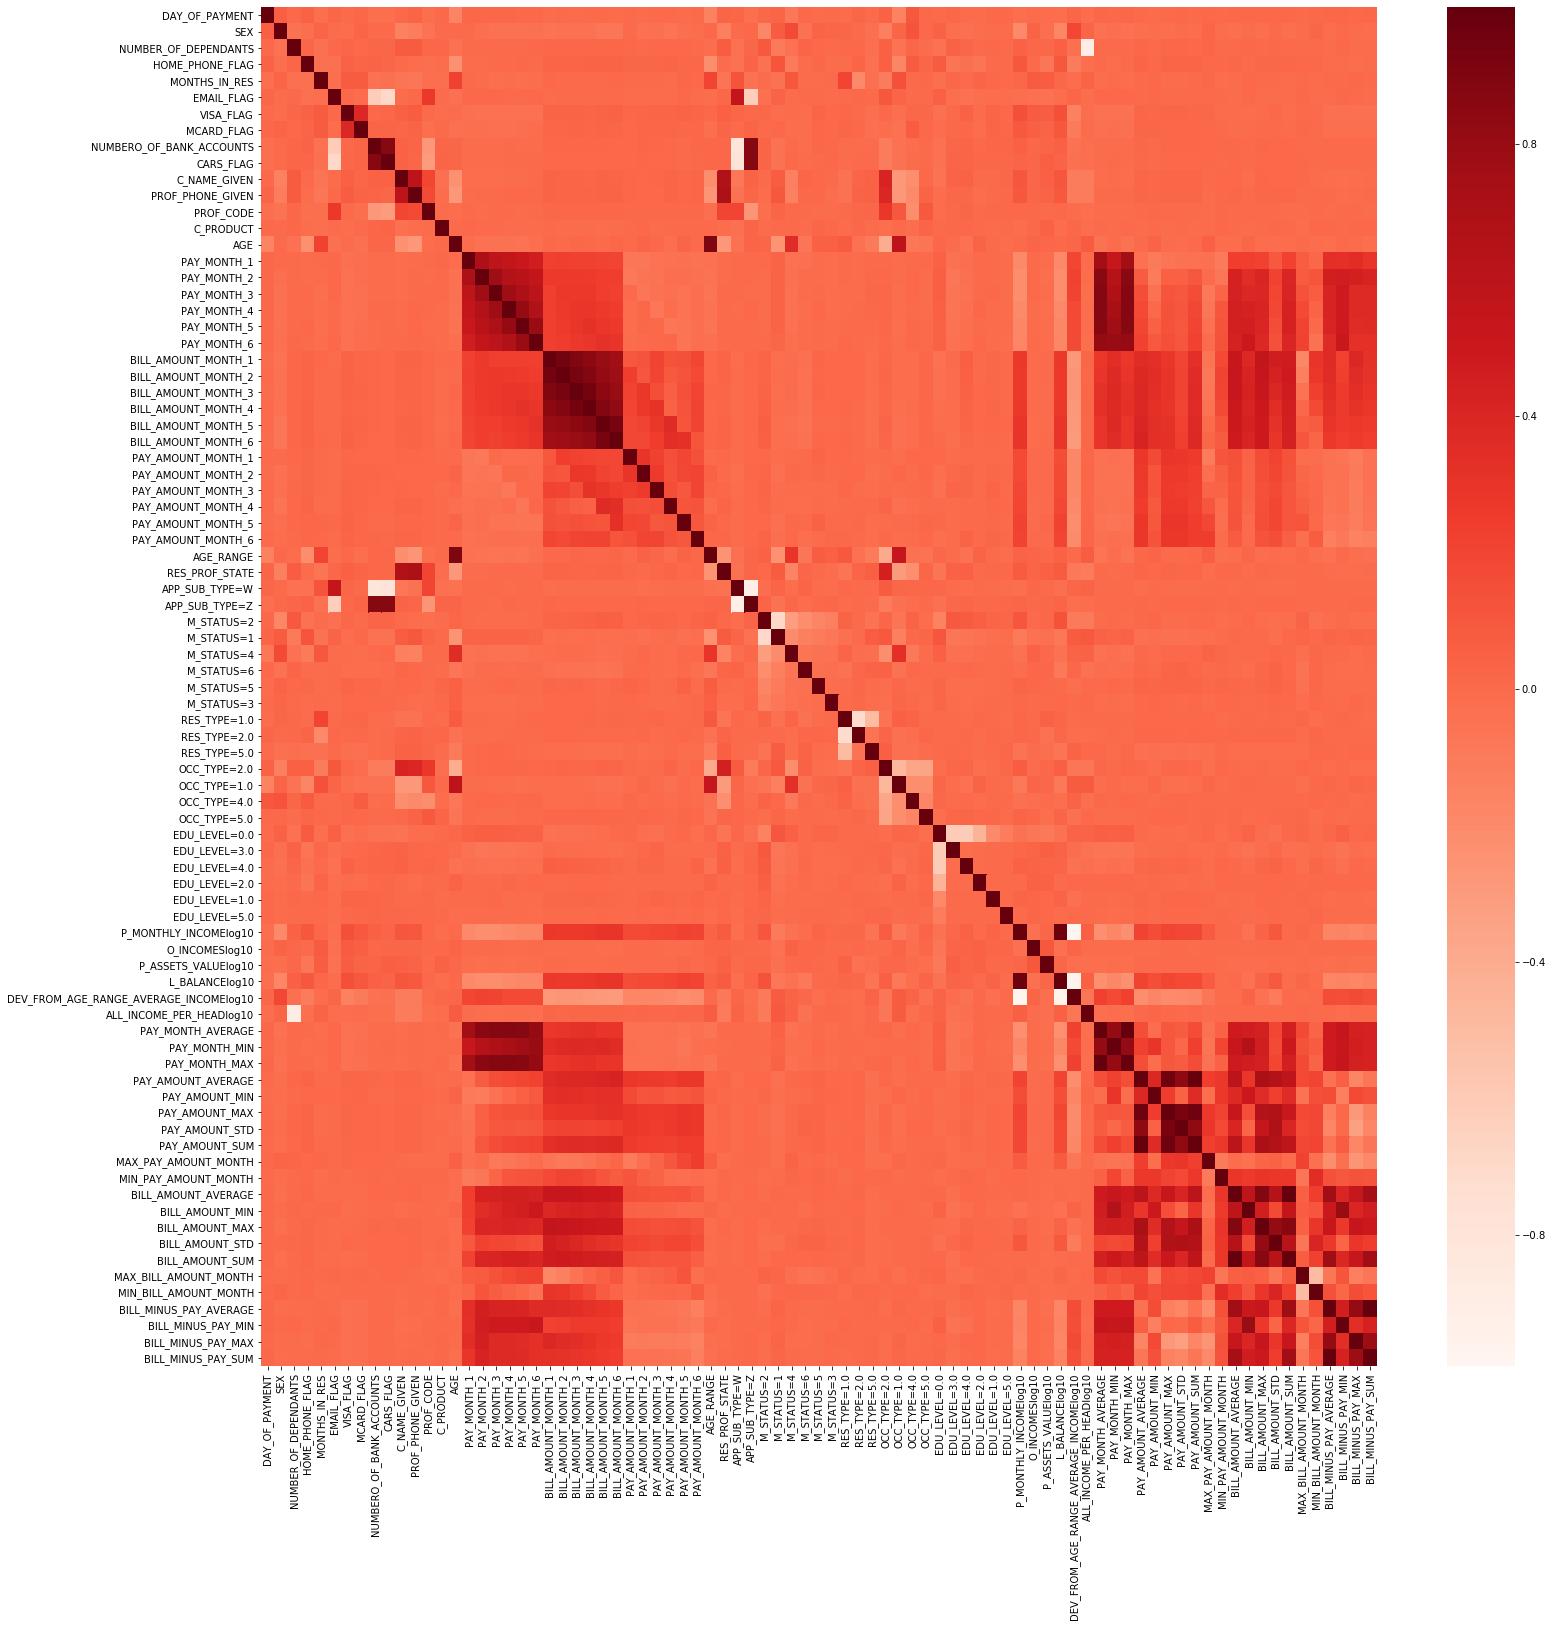

In [11]:
correlation_matrix = train_df[unique_features_names].corr()
np.shape(correlation_matrix)

plt.figure(figsize=(25,25))
sns.heatmap(correlation_matrix, annot=False,cmap=plt.cm.Reds)
plt.show()

In [12]:
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

In [13]:
correlated_features

{'BILL_AMOUNT_AVERAGE',
 'BILL_MINUS_PAY_AVERAGE',
 'L_BALANCElog10',
 'PAY_AMOUNT_AVERAGE',
 'PAY_AMOUNT_MAX',
 'PAY_MONTH_AVERAGE',
 'P_MONTHLY_INCOMElog10'}

In [14]:
selected_features = [col for col in unique_features_names if col not in correlated_features]
len(selected_features)

76

## Save filtered data

In [15]:
customer_df = alldf[['ID','TARGET','train_or_test']+selected_features]

In [16]:
customer_df.to_csv('../data/selected_df.csv',index=False)